In [17]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O daily-min-temperatures.csv

--2021-05-19 18:42:12--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K   229KB/s    in 0.3s    

2021-05-19 18:42:14 (229 KB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



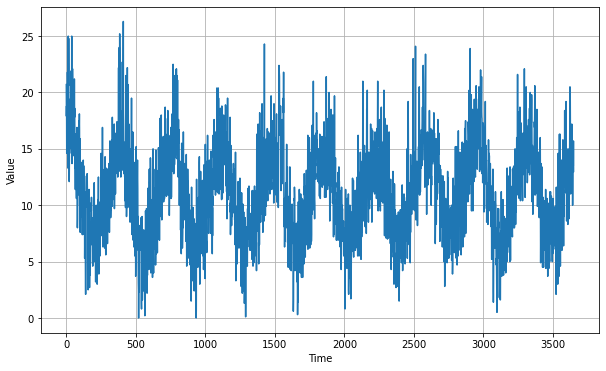

In [8]:
import csv
time_step = []
temps = []
cnt = 0
with open('daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(cnt)
        cnt = cnt +1
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 2500

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# window_size = 60
# batch_size = 32
# shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 131ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 1s 136ms/step - loss: 30.7697 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 1s 130ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 1s 121ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 1s 125ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 1s 125ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 1s 126ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 1s 124ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 1s 128ms/step - loss: 18.2363 - mae: 18.7316
Epoch 10/100
10/

(1e-08, 0.0001, 0.0, 30.0)

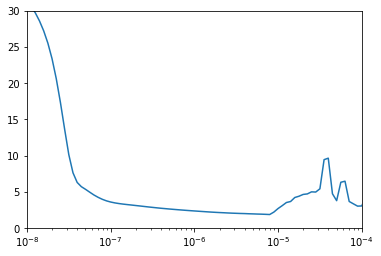

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150,verbose=1)                              
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 4s 69ms/step - loss: 15.8473 - mae: 16.3396
Epoch 2/150
25/25 [==============================] - 2s 82ms/step - loss: 2.9314 - mae: 3.3996
Epoch 3/150
25/25 [==============================] - 2s 81ms/step - loss: 2.0152 - mae: 2.4714
Epoch 4/150
25/25 [==============================] - 2s 69ms/step - loss: 1.9115 - mae: 2.3666
Epoch 5/150
25/25 [==============================] - 2s 68ms/step - loss: 1.8753 - mae: 2.3298
Epoch 6/150
25/25 [==============================] - 2s 69ms/step - loss: 1.8384 - mae: 2.2917
Epoch 7/150
25/25 [==============================] - 2s 69ms/step - loss: 1.8145 - mae: 2.2668
Epoch 8/150
25/25 [==============================] - 2s 77ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 2s 81ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 2s 82ms/step - loss: 1.7410 - mae: 2.1911
Epoch 11/150
25/25 [===========================

<Figure size 432x288 with 0 Axes>

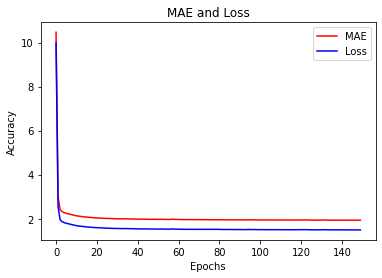

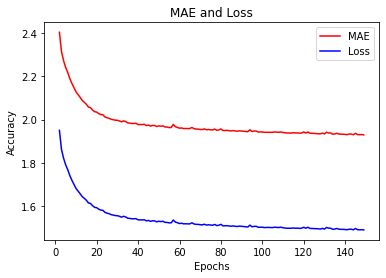

<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[2:]
mae_zoom = mae[2:]
loss_zoom = loss[2:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

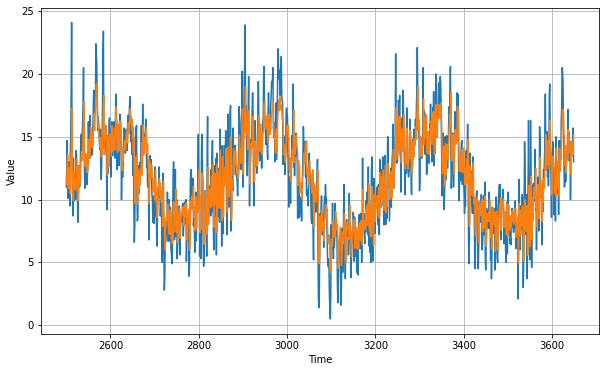

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [59]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [60]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.104341

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8031775

In [64]:
model.save('series.h5')